# Imports

In [1]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType, MapType
from pyspark.ml.feature import Bucketizer
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from pyspark.sql import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

# Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/12/05 23:24:56 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.58 instead (on interface en0)
24/12/05 23:24:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 23:24:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [9]:
if local:
    # Use sample with users that have left many reviews
    game_reviews = spark.read.parquet('data/many_reviews_users_parquet')
    games = spark.read.parquet('data/steam_games_parquet')
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

games = game_reviews.select('app_id').distinct().join(games, "app_id", 'inner').cache()
game_reviews: DataFrame = game_reviews.persist()

In [28]:
game_reviews.printSchema()

root
 |-- author_steamid: long (nullable = true)
 |-- review_count: long (nullable = true)
 |-- recommended_true_count: long (nullable = true)
 |-- recommended_false_count: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- app_id: long (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: long (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: integer (nullable = true)
 |-- timestamp_updated: integer (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integ

# K-Means Clustering

In [56]:
from pyspark.ml.feature import CountVectorizer, VectorAssembler, MinMaxScaler
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans

# Step 1: Aggregate games by user
user_games = (
    game_reviews.groupBy("author_steamid")
    .agg(
        F.collect_list(F.when(F.col("recommended") == True, F.col("app_id").cast("string"))).alias("positively_recommended"),
        F.collect_list(F.when(F.col("recommended") == False, F.col("app_id").cast("string"))).alias("negatively_recommended"),
        F.avg("author_playtime_at_review").alias("avg_playtime"),
        F.count("app_id").alias("total_reviews"),
        F.sum("votes_helpful").alias("total_votes_helpful"),
        F.sum("votes_funny").alias("total_votes_funny"),
        F.avg("weighted_vote_score").alias("avg_weighted_vote_score"),
        F.first("author_num_games_owned").alias("num_games_owned"),  # Assuming constant per user
        F.first("author_num_reviews").alias("num_reviews_written")
    )
).cache()

# Step 2: Apply CountVectorizer
positive_vectorizer = CountVectorizer(inputCol="positively_recommended", outputCol="positive_vector", vocabSize=315)
negative_vectorizer = CountVectorizer(inputCol="negatively_recommended", outputCol="negative_vector", vocabSize=315)

positive_model = positive_vectorizer.fit(user_games)
negative_model = negative_vectorizer.fit(user_games)

user_games = positive_model.transform(user_games)
user_games = negative_model.transform(user_games)

# Step 3: Normalize numerical features
numerical_cols = ["avg_playtime", "total_reviews", "total_votes_helpful", "total_votes_funny", 
                  "avg_weighted_vote_score", "num_games_owned", "num_reviews_written"]
assembler_numeric = VectorAssembler(inputCols=numerical_cols, outputCol="numeric_features")
numeric_features = assembler_numeric.transform(user_games)

scaler = MinMaxScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")
scaler_model = scaler.fit(numeric_features)
user_games = scaler_model.transform(numeric_features)

# Step 4: Combine all features
assembler = VectorAssembler(
    inputCols=["positive_vector", "negative_vector", "scaled_numeric_features"],
    outputCol="features"
)
user_features = assembler.transform(user_games)

# Step 5: Train KMeans model
kmeans = KMeans(k=6, seed=1)  # Adjust k as needed
model = kmeans.fit(user_features)

# Step 6: Assign clusters
clustered_users = model.transform(user_features)
clustered_users.select("author_steamid", "prediction").show()


+-----------------+----------+
|   author_steamid|prediction|
+-----------------+----------+
|76561197960269579|         5|
|76561197960272423|         0|
|76561197960366167|         0|
|76561197960393401|         2|
|76561197960410177|         0|
|76561197961493450|         0|
|76561197962185897|         0|
|76561197962523861|         0|
|76561197963587596|         3|
|76561197964606451|         0|
|76561197964871184|         0|
|76561197966019549|         0|
|76561197966055543|         0|
|76561197966144571|         0|
|76561197966378621|         5|
|76561197966489347|         4|
|76561197966530890|         2|
|76561197966759219|         0|
|76561197967363199|         0|
|76561197967998740|         3|
+-----------------+----------+
only showing top 20 rows



Training KMeans for k=2


Training KMeans for k=3


Training KMeans for k=4


Training KMeans for k=5


Training KMeans for k=6


Training KMeans for k=7


Training KMeans for k=8


Training KMeans for k=9


Training KMeans for k=10


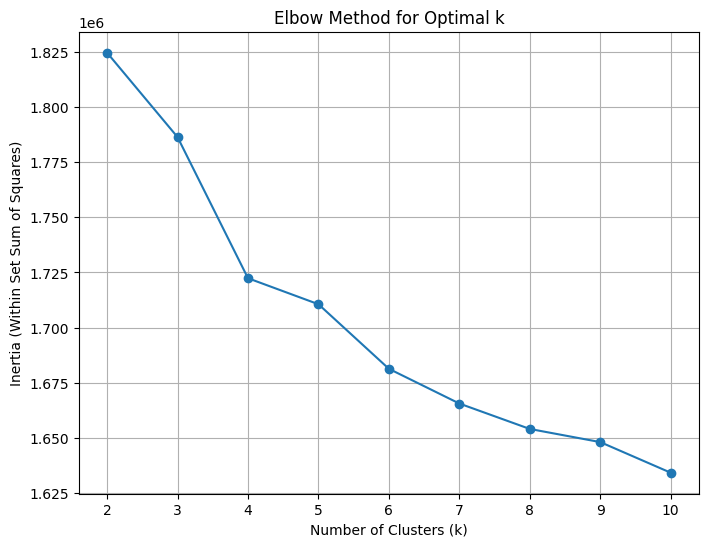

In [ ]:

# Elbow method: Compute inertia for different k values
k_values = list(range(2, 11)) 
inertia = []

for k in k_values:
    print(f"Training KMeans for k={k}")

    kmeans = KMeans(k=k, seed=1234)  # Adjust k as needed
    model = kmeans.fit(user_features)
    
    clustered_users = model.transform(user_features)

    
    # Compute WSSSE (Within Set Sum of Squared Errors)
    rmse_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
    silhouette = rmse_evaluator.evaluate(clustered_users)
    inertia.append(model.summary.trainingCost)

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within Set Sum of Squares)")
plt.grid()
plt.show()


In [57]:
from pyspark.sql import functions as F

# Step 1: Join user clusters with reviews
user_reviews_with_cluster = game_reviews.join(
    clustered_users.select("author_steamid", "prediction"),
    on="author_steamid",
    how="inner"
)

# Step 2: Join with the game dataset to get genres
reviews_with_genres = user_reviews_with_cluster.join(
    games,  # Replace with your game dataset
    on="app_id",
    how="inner"
)

# Step 3: Explode genres array
exploded_genres = reviews_with_genres.withColumn("genre", F.explode(F.col("genres")))

# Step 4: Count genre frequencies by cluster
genre_frequencies = (
    exploded_genres.groupBy("prediction", "genre")
    .agg(F.count("*").alias("genre_count"))
    .orderBy("prediction", "genre_count", ascending=False)
)

# Step 5: Show results
genre_frequencies.show(truncate=False)


+----------+---------------------+-----------+
|prediction|genre                |genre_count|
+----------+---------------------+-----------+
|5         |Action               |58665      |
|5         |Adventure            |44056      |
|5         |Indie                |29922      |
|5         |RPG                  |26622      |
|5         |Simulation           |19291      |
|5         |Strategy             |17471      |
|5         |Massively Multiplayer|8038       |
|5         |Casual               |6200       |
|5         |Free to Play         |3317       |
|5         |Early Access         |2454       |
|5         |Sports               |1609       |
|5         |Racing               |1539       |
|5         |Photo Editing        |855        |
|5         |Animation & Modeling |855        |
|5         |Utilities            |855        |
|5         |Design & Illustration|855        |
|5         |Violent              |8          |
|5         |Nudity               |8          |
|4         |A

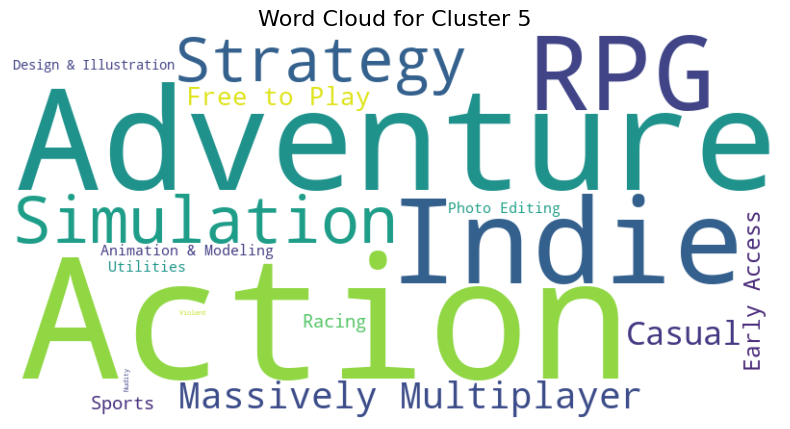

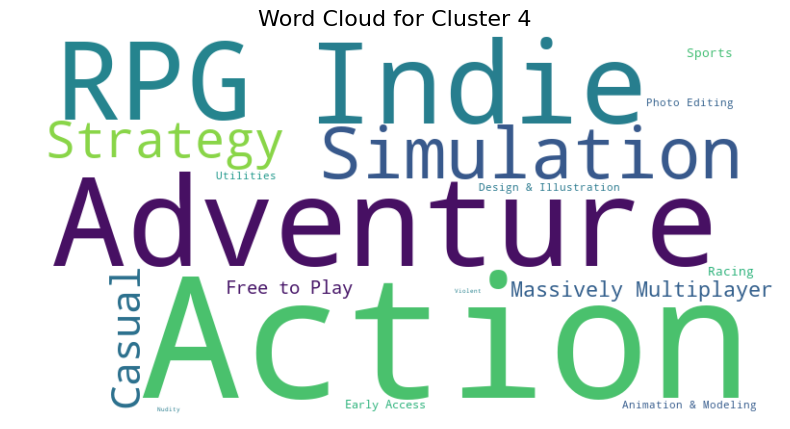

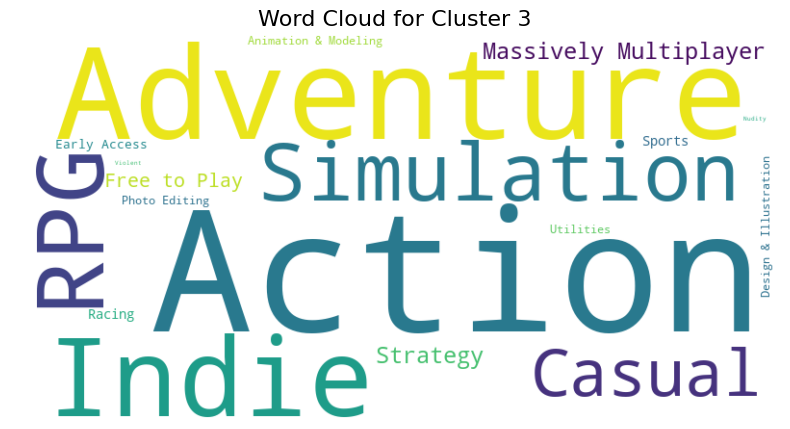

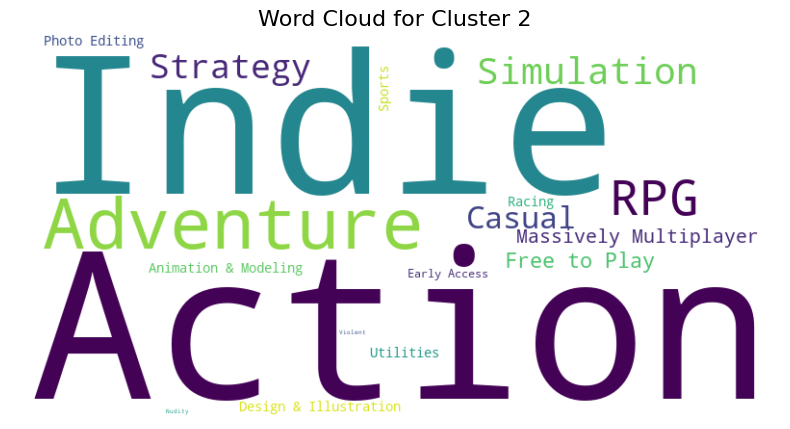

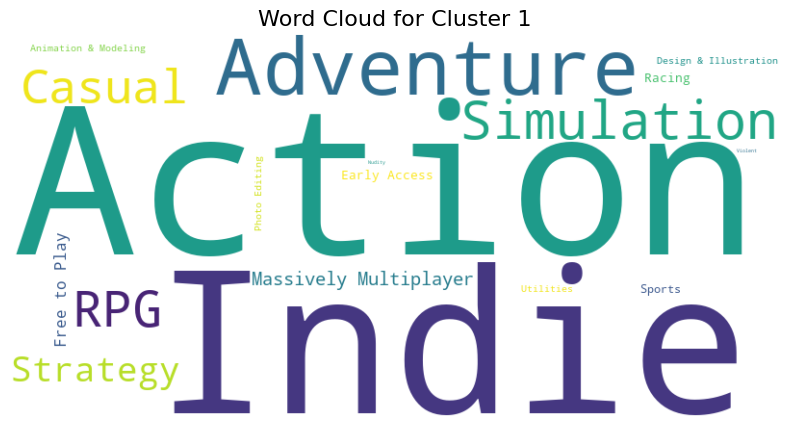

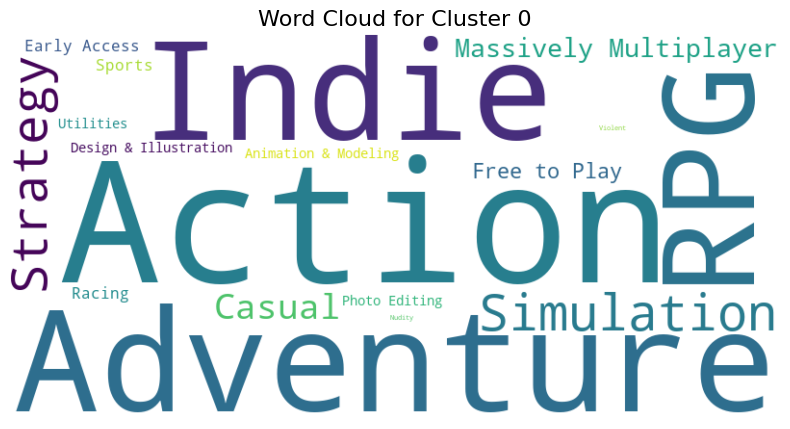

In [58]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Convert genre frequencies to a Pandas DataFrame for easier manipulation
genre_frequencies_pd = genre_frequencies.toPandas()

# Loop through each cluster to generate and visualize a word cloud
clusters = genre_frequencies_pd['prediction'].unique()

for cluster in clusters:
    # Filter data for the current cluster
    cluster_data = genre_frequencies_pd[genre_frequencies_pd['prediction'] == cluster]
    
    # Convert genres and their frequencies to a dictionary
    genre_dict = dict(zip(cluster_data['genre'], cluster_data['genre_count']))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_dict)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster}", fontsize=16)
    plt.show()
